### Define some functions

In [65]:
import scipy
import pylab
import numpy as np
import matplotlib
import matplotlib.patches as patches
import astroquery
from astroquery.splatalogue import Splatalogue,utils
from astropy import units as u
from astropy.table import vstack, Table
from astropy import table as at
from decimal import *
from astropy.table import Column

getcontext().prec = 2

%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='sans-serif')
matplotlib.rcParams.update({'font.size':9})

def atmosphere(file):
    #read in a file of atmospheric transmission vs. frequency
    inp1 = file
    input1 = open(inp1,'r')
    newline1 = input1.readlines()
    input1.close()
    fghz = pylab.zeros(np.size(newline1))
    trans = pylab.zeros(np.size(newline1))
    for num,line in enumerate(newline1):
        splitline = str.split(line)
        fghz[num]   = float(splitline[0]) 
        trans[num]  = float(splitline[1])
    return fghz, trans


def trimmed_query(*args,**kwargs):
    # Define the Splatalogue parameters you want returned
    columns = ('Species','Resolved QNs','Freq-GHz',
                    'Meas Freq-GHz','Log<sub>10</sub> (A<sub>ij</sub>)',
                    'E_U (K)')
    table = S.query_lines(*args, **kwargs)[columns]
    table.rename_column('Log<sub>10</sub> (A<sub>ij</sub>)','log10(Aij)')
    table.rename_column('E_U (K)','EU_K')
    table.rename_column('Resolved QNs','QNs')
    table['EU_K'].format = '5.2f'
    table['EU_K'][:] = 100*table['EU_K'][:]
    table['EU_K'] = table['EU_K'].astype(int)
    table= at.unique(table,keys=['EU_K'])
    table['EU_K'] = table['EU_K'].astype(float)
    table['EU_K'][:] = table['EU_K'][:]/100.0
    col_freq = Column(name='Freq_GHz', data=np.maximum(pylab.array(table['Freq-GHz'][:]),pylab.array(table['Meas Freq-GHz'][:])))
    table.add_column(col_freq,index=2)
    table.remove_columns(['Freq-GHz','Meas Freq-GHz'])
    table= at.unique(table,keys=['Freq_GHz'])
    return table

def splat(bbs,printit=1,*args,**kwargs):
    # Print out a table of molecule transitions lying in this spectral setup
    for i,bb in enumerate(bbs):
        low,hi = bb-1.875/2.0, bb+1.875/2.0
        table = trimmed_query(low*u.GHz, hi*u.GHz)
        if printit == 1:
            print ''
            print '****************************************'
            print 'Sub-Band %i  %3.2f - %3.2f GHz'%(i,low,hi)
            print '****************************************'
            print table
        if i == 0:
            table_lo = table
        if i == 1:
            table_lo = vstack([table_lo,table])
        if i == 2:
            table_hi = table
        if i == 3:
            table_hi = vstack([table_hi,table])
        
    # Get arrays of frequency, chemical formula for plotting 
    # observed transitions in each setup
    #freq_lo = np.maximum(pylab.array(table_lo['Freq-GHz']),
    #                     pylab.array(table_lo['Meas Freq-GHz']))
    freq_lo = np.array(table_lo['Freq_GHz'][:])
    mols_lo = np.array([specy.replace('vt=0','').replace('v=0','').replace('3&Sigma;','').replace('t-','')  
                        for specy in table_lo['Species'].data])
    #freq_hi = np.maximum(pylab.array(table_hi['Freq-GHz']),
    #                     pylab.array(table_hi['Meas Freq-GHz']))
    freq_hi = np.array(table_hi['Freq_GHz'][:])
    mols_hi = np.array([specy.replace('vt=0','').replace('v=0','').replace('3&Sigma;','').replace('t-','')  
                        for specy in table_hi['Species'].data])
    return freq_lo, mols_lo, freq_hi, mols_hi

def whichmol(specy):
    # IJMC, 2017/04/09, 18:36 <--- co-author credit!
    color = -1
    for ii, this_mol in enumerate(allmol):
        stripped_list = [mol.strip() for mol in this_mol]
        if specy in stripped_list:
            color = ii
    return color

def lsb_plot(LO,bbs,ml,fl,ls,pc,lb):
    # Plot lines in the lower sideband
    fig1 = pylab.figure(1,figsize=(12,5))
    ax = fig1.add_subplot(111)
    #fghz,trans = atmosphere('atmosphereplot.data')
    #pylab.plot(fghz,trans,color='k')
    for i,c in enumerate(pc):
        pylab.vlines(0,0,1, color=c,linestyle=ls[i], label=lb[i])
    pylab.xlim([LO-8.0,LO-4.0])
    pylab.ylim([0,1])
    pylab.text(LO-7.7,0.5, "LSB", fontsize=30)
    pylab.xlabel('Frequency (GHz)', fontsize=20)
    pylab.ylabel('Atmospheric Transmissivity', fontsize=15)
    ax.add_patch(patches.Rectangle((bbs[0]-1.875/2.0,0), 1.875, 1.0,
                                   facecolor="yellow",edgecolor="none",alpha=0.1))
    ax.add_patch(patches.Rectangle((bbs[1]-1.875/2.0,0), 1.875, 1.0,
                                   facecolor="yellow",edgecolor="none",alpha=0.1))
    for i,f in enumerate(fl):
        pylab.vlines(f,0,1, linestyle=ls[whichmol(ml[i])],colors=pc[whichmol(mols_lo[i])])
        p_i = 1-(i%10)/10.0 - 0.05
        pylab.text(f,p_i,ml[i],fontsize=14,color=pc[whichmol(ml[i])])
    leg = pylab.legend(loc=3)
    for color,text in zip(pc,leg.get_texts()):
        text.set_color(color)
    return 

def usb_plot(LO,bbs,mh,fh,ls,pc,lb):
    # plot lines in the upper sideband
    fig2 = pylab.figure(2,figsize=(12,5))
    ax = fig2.add_subplot(111)
    #fghz,trans = atmosphere('atmosphereplot.data')
    #pylab.plot(fghz,trans,color='k')
    for i,c in enumerate(pc):
        pylab.vlines(0,0,1, color=c,linestyle=ls[i], label=lb[i])
    pylab.xlim([LO+4.0,LO+8.0])
    pylab.ylim([0,1])
    pylab.text(LO+4.3,0.5, "USB", fontsize=30)
    pylab.xlabel('Frequency (GHz)', fontsize=20)
    pylab.ylabel('Atmospheric Transmissivity', fontsize=15)
    ax.add_patch(patches.Rectangle((BB[2]-1.875/2.0,0), 1.875, 1.0,
                                   facecolor="yellow",edgecolor="none",alpha=0.1))
    ax.add_patch(patches.Rectangle((BB[3]-1.875/2.0,0), 1.875, 1.0,
                                   facecolor="yellow",edgecolor="none",alpha=0.1))
    for i,f in enumerate(fh):
        pylab.vlines(f,0,1, colors=pc[whichmol(mh[i])])
        p_i = 1-(i%10)/10.0 - 0.05
        pylab.text(f,p_i,mh[i],fontsize=14,color=pc[whichmol(mh[i])])
    leg = pylab.legend(loc=3)
    for color,text in zip(pc,leg.get_texts()):
        text.set_color(color)
    return



### Identify molecules of interest for searching Splatalogue

In [72]:
# Sort lists of molecules into groups of interest
mol_main = pylab.array([' HCN ',' HCO+',' HNC ',' CS ',' HNCO ',' N2H+'])
mol_PDR = pylab.array([' CO ',' CCH ',' c-C3H2 '])
mol_temp = pylab.array([' H2CO ',' CH3CN ',' CH3CCH '])
mol_shock = pylab.array([' SiO ',' SO '])
mol_dense = pylab.array([' HC3N ', ' OCS ', ' H2CS ',' HOCO+', ' NS ', ' HCO '])
mol_COM = pylab.array([' NH2CHO ',' CH2NH ',' CH3OH ',' CH3SH ', ' CH3CHO ',' NH2CN ',' CH3C2H ',' CH2CO ',' HCOOH '])
mol_iso = pylab.array([' 13CO ',' C18O ',' H13CN ',' H13CO+','HN13C',' HC15N ',' 13CS '])
mol_deut = pylab.array([' DCN ',' DCO+',' N2D+',' DNC ',' NH2D ',' NHD2 '])

pcolors = ['black','green','red','cyan','blue','grey','magenta','magenta']
linestyles = ['solid','dotted','solid','solid','solid','solid','solid','dashed']
labels = ['Bright', 'PDR','Temperature probe','Shock tracer','Dense gas','COM',
          'Rare Isotopologue','Deuterated']
allmol = [mol_main, mol_PDR, mol_temp, mol_shock, mol_dense, mol_COM, mol_iso, mol_deut]

# Select groups of interest
chems = ''
for mol in np.hstack((mol_main,mol_PDR,mol_temp,mol_shock,mol_dense,mol_COM,mol_iso,mol_deut)):
    chems = chems+'('+mol+')'+'|'

# Define Splatalogue query parameters, including cutoff upper energy for transitions
S = Splatalogue(energy_max=50, energy_type='eu_k',line_lists=['JPL','CDMS'],noHFS=0, 
                chemical_name=chems[:-1])

# Current ACES Setup

//anaconda/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)



****************************************
Sub-Band 0  88.55 - 90.43 GHz
****************************************
 Species        QNs       Freq_GHz log10(Aij)  EU_K
--------- --------------- -------- ---------- -----
   HCNv=0     J=1-0,F=1-1 88.63042   -4.61844  4.25
CH3CHOv=0 8(0,8)-7(1,6),E 89.17716    -8.8599 33.19
  HCO+v=0             1-0 89.18852   -4.38103  4.28

****************************************
Sub-Band 1  90.42 - 92.30 GHz
****************************************
Species        QNs       Freq_GHz log10(Aij)  EU_K
-------- --------------- -------- ---------- -----
  HNCv=0           J=1-0 90.66357   -4.57032  4.35
 HC3Nv=0  J=10-9,F=10-10 90.97744   -6.71276 24.01
CH3CNv=0 5(2)-4(2),F=5-5  91.9792   -5.83381 41.82
CH3CNv=0 5(1)-4(1),F=5-5 91.98403   -5.77571 20.38
CH3CNv=0 5(0)-4(0),F=5-5 91.98564   -5.75795 13.24

****************************************
Sub-Band 2  100.43 - 102.30 GHz
****************************************
 Species          QNs          Freq_GHz lo

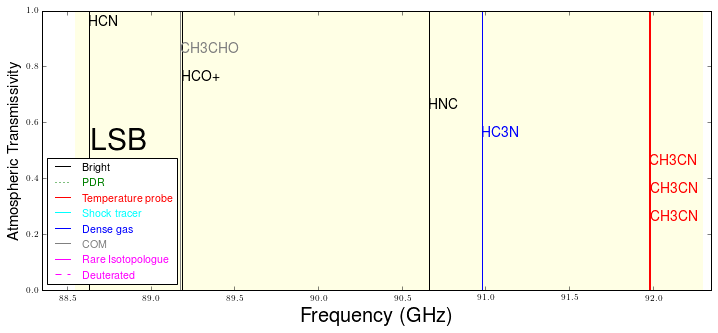

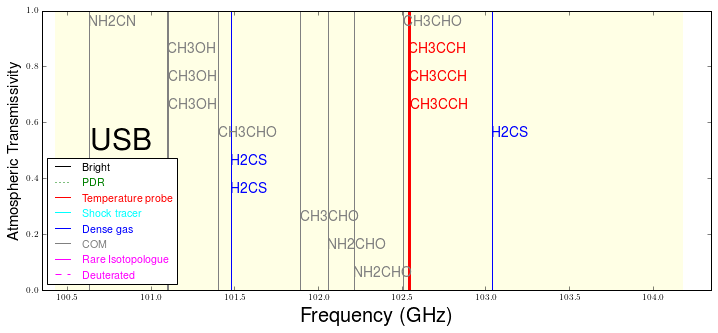

In [66]:
# Input the information about your chosen ALMA spectral setup    
LO = 96.35
BB = pylab.array([89.488,91.362,101.365,103.24])

##################
#Query Splatalogue
freq_lo, mols_lo, freq_hi, mols_hi = splat(bbs=BB)  

# Plot the LSB
lsb_plot(LO=LO,bbs=BB,ml=mols_lo,fl=freq_lo,ls=linestyles,pc=pcolors,lb=labels)

# Plot the USB    
usb_plot(LO=LO,bbs=BB,mh=mols_hi,fh=freq_hi,ls=linestyles,pc=pcolors,lb=labels)


# Alternative Setup 1 (tweak to include HNCO, 2x HC3N)


****************************************
Sub-Band 0  87.55 - 89.43 GHz
****************************************
 Species          QNs         Freq_GHz log10(Aij)  EU_K
--------- ------------------- -------- ---------- -----
   NH2CHO       7(2,5)-8(0,8) 87.80347   -7.36578 40.57
   NH2CHO 4(1,3)-3(1,2),F=4-4 87.84853   -5.57073 13.52
  HNCOv=0 4(0,4)-3(0,3),F=3-3 87.92435   -6.62871 10.54
   HCNv=0         J=1-0,F=1-1 88.63042   -4.61844  4.25
CH3CHOv=0     8(0,8)-7(1,6),E 89.17716    -8.8599 33.19
  HCO+v=0                 1-0 89.18852   -4.38103  4.28

****************************************
Sub-Band 1  89.42 - 91.30 GHz
****************************************
Species      QNs       Freq_GHz log10(Aij)  EU_K
------- -------------- -------- ---------- -----
 HNCv=0          J=1-0 90.66357   -4.57032  4.35
HC3Nv=0 J=10-9,F=10-10 90.97744   -6.71276 24.01

****************************************
Sub-Band 2  99.43 - 101.30 GHz
****************************************
   Species      

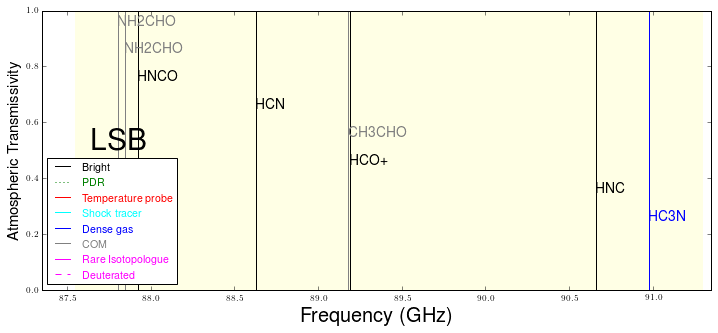

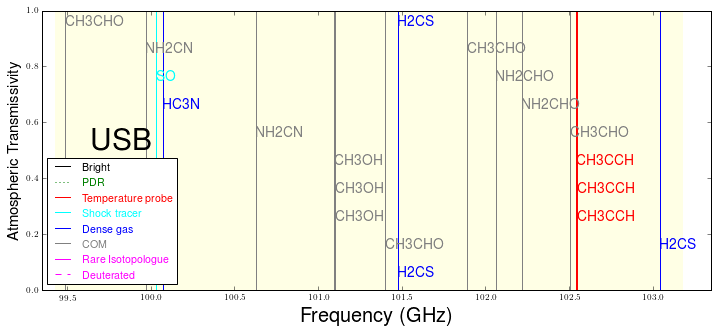

In [67]:
# Input the information about your chosen ALMA spectral setup    
LO = 95.35
BB = pylab.array([88.488,90.362,100.365,102.24])

##################
#Query Splatalogue
freq_lo, mols_lo, freq_hi, mols_hi = splat(bbs=BB)  

# Plot the LSB
lsb_plot(LO=LO,bbs=BB,ml=mols_lo,fl=freq_lo,ls=linestyles,pc=pcolors,lb=labels)

# Plot the USB    
usb_plot(LO=LO,bbs=BB,mh=mols_hi,fh=freq_hi,ls=linestyles,pc=pcolors,lb=labels)

# Alternative Setup 2 (Major change to include isotopologues)


****************************************
Sub-Band 0  85.56 - 87.44 GHz
****************************************
   Species                 QNs              Freq_GHz log10(Aij)  EU_K
------------- ----------------------------- -------- ---------- -----
        HOCO+                 4(1,3)-3(1,2) 85.85286   -4.91095 47.64
         NH2D       1(1,1)0s-1(0,1)0a,F=0-1 85.92478   -4.62958 20.67
     HC15Nv=0                           1-0 86.05496   -4.62943  4.12
SO3&Sigma;v=0                     2(2)-1(1) 86.09395   -5.27985 19.31
     H13CNv=0                   J=1-0,F=1-1 86.33877   -4.62444  4.14
       NH2CHO           7(1,6)-7(0,7),F=7-7 86.38195   -5.65911 32.47
          HCO 1(0,1)-0(0,0),J=3/2-1/2,F=2-1 86.67076   -5.32891  4.17
          HCO 1(0,1)-0(0,0),J=3/2-1/2,F=1-0 86.70836    -5.3377  4.16
          HCO 1(0,1)-0(0,0),J=1/2-1/2,F=1-1 86.77746   -5.33663  4.18
       SiOv=0                           2-1 86.84696   -4.53354  6.25
    CH3CHOv=0               2(1,1)-1(0,1),E  87

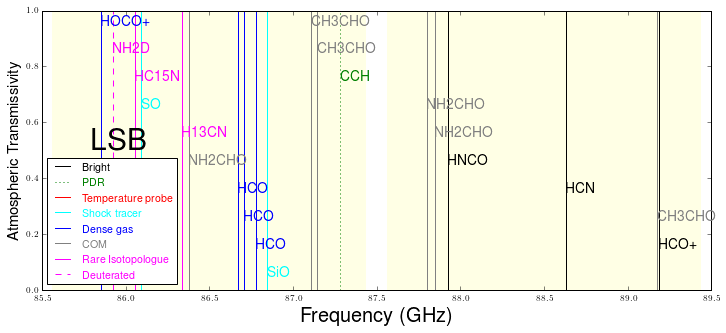

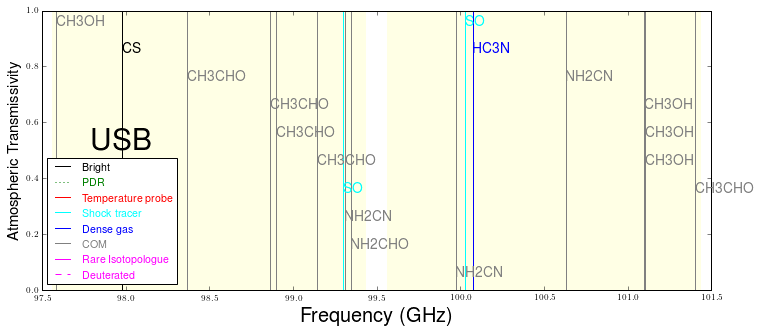

In [73]:
# Input the information about your chosen ALMA spectral setup    
LO = 93.5
BB = pylab.array([86.5,88.5,98.5,100.5])

##################
#Query Splatalogue
freq_lo, mols_lo, freq_hi, mols_hi = splat(bbs=BB)  

# Plot the LSB
lsb_plot(LO=LO,bbs=BB,ml=mols_lo,fl=freq_lo,ls=linestyles,pc=pcolors,lb=labels)


# Plot the USB    
usb_plot(LO=LO,bbs=BB,mh=mols_hi,fh=freq_hi,ls=linestyles,pc=pcolors,lb=labels)

